In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning & Preprocess

In [2]:
# dass_42 = None
# with open("DASS/codebook.txt","r") as f:
#     dass_42 = pd.DataFrame(
#         [line[3:-1].strip() for line in f.readlines() if line[0] == "Q"],
#         index=[f"Q{i}" for i in range(1,43)],
#         columns = ["question"]
#     )
#     dass_42.index.name = "qid"
    

Qit = lambda l: [f"Q{x}" for x in l]

Depression= Qit([3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42])
Anxiety= Qit([2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41])
Stress= Qit([1, 6, 8, 11, 12, 14, 18, 22, 27, 29, 32, 33, 35, 39])

# dass_42["DAS"] = ""
# dass_42["DAS"].loc[Depression] = "D"
# dass_42["DAS"].loc[Anxiety] = "A"
# dass_42["DAS"].loc[Stress] = "S"
# dass_42.to_csv("dass_42.csv")

dass_42 = pd.read_csv("dass_42.csv",index_col="qid")

In [3]:
survey_data = pd.read_csv("DASS/data.csv",delimiter="\t")
print(survey_data.shape)
# dass_df.head()

(39775, 172)


### DASS-42 Score level Interpretation

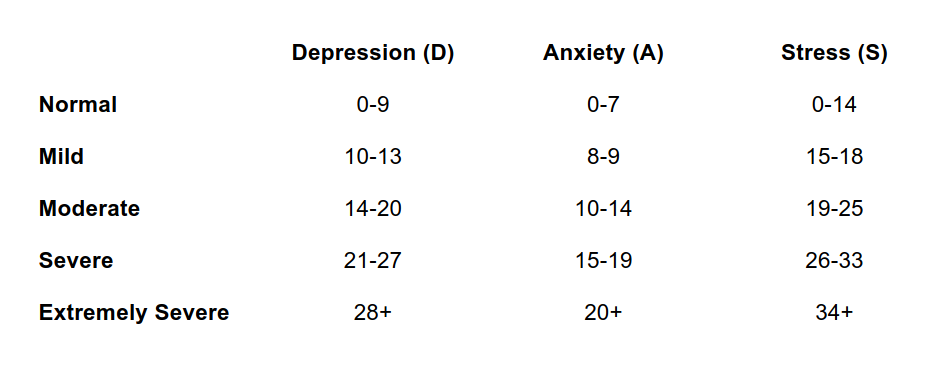

**Answer Mapping**
```
0 = Did not apply to me at all 
1 = Applied to me to some degree, or some of the time
2 = Applied to me to a considerable degree, or a good part of the time
3 = Applied to me very much, or most of the time
```

In [4]:
def how_severe(DAS: str, score: int)->int:
    """
        Normal, Mild, Moderate, Sever, Extremely Severe 
    """
    match DAS:
        case "D":
            if score<=9: return 0
            elif score<=13: return 1
            elif score<=20: return 2
            elif score<=27: return 3
            else: return 4
        case "A":
            if score<=7: return 0
            elif score<=9: return 1
            elif score<=14: return 2
            elif score<=19: return 3
            else: return 4
        case "S":
            if score<=14: return 0
            elif score<=18: return 1
            elif score<=25: return 2
            elif score<=33: return 3
            else: return 4
    return -1
            

In [5]:
survey_data = survey_data.drop(columns=["source", "introelapse", "testelapse", "surveyelapse","screensize","uniquenetworklocation","major"])

survey_data["engnat"] = survey_data["engnat"].apply(lambda x: 0 if x==2 else x)
survey_data["voted"] = survey_data["voted"].apply(lambda x: 0 if x==2 else x)

# Making all sub to single religion (Christion) 4,5,6,7 -> 4
chr = {5,6,7}
survey_data["religion"] = survey_data["religion"].apply(lambda x: 4 if x in chr else x)

# Country iso to int: str -> int
country_map = {iso_c:i for i,iso_c in enumerate(survey_data["country"].unique())} 
survey_data["country"] =  survey_data["country"].apply(lambda x: country_map[x])


Ait = lambda qids: [qid + "A" for qid in qids]


dass_qa = survey_data[[*Ait(Depression),*Ait(Anxiety),*Ait(Stress)]]-1 # -1 to shift values to left 1,2,3,4 -> 0,1,2,3
survey_q = survey_data.iloc[:,126:]


# Calculate Scores & Levels
D_level = (dass_qa[Ait(Depression)].sum(axis=1)).apply(lambda x: how_severe("D",x))
A_level = (dass_qa[Ait(Anxiety)].sum(axis=1)).apply(lambda x: how_severe("A",x))
S_level = (dass_qa[Ait(Stress)].sum(axis=1)).apply(lambda x: how_severe("S",x))

del survey_data

# Data Analysis

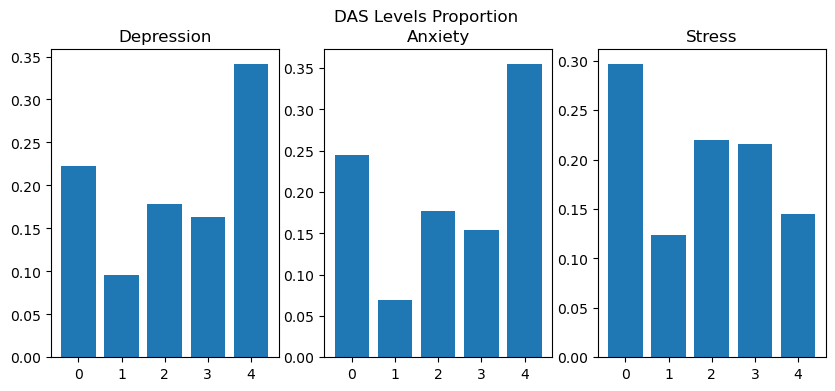

In [6]:
plt.figure(figsize=(10,4))
i=1
das_names_ = ["Depression","Anxiety","Stress"]
for level in D_level,A_level,S_level:
    plt.subplot(1,3,i)
    counts_ = level.value_counts().sort_index(ascending=True)
    plt.bar(counts_.index.map(lambda x: str(x)), counts_.values/counts_.values.sum())
    plt.title(das_names_[i-1])
    i+=1 
plt.suptitle("DAS Levels Proportion")
plt.show()

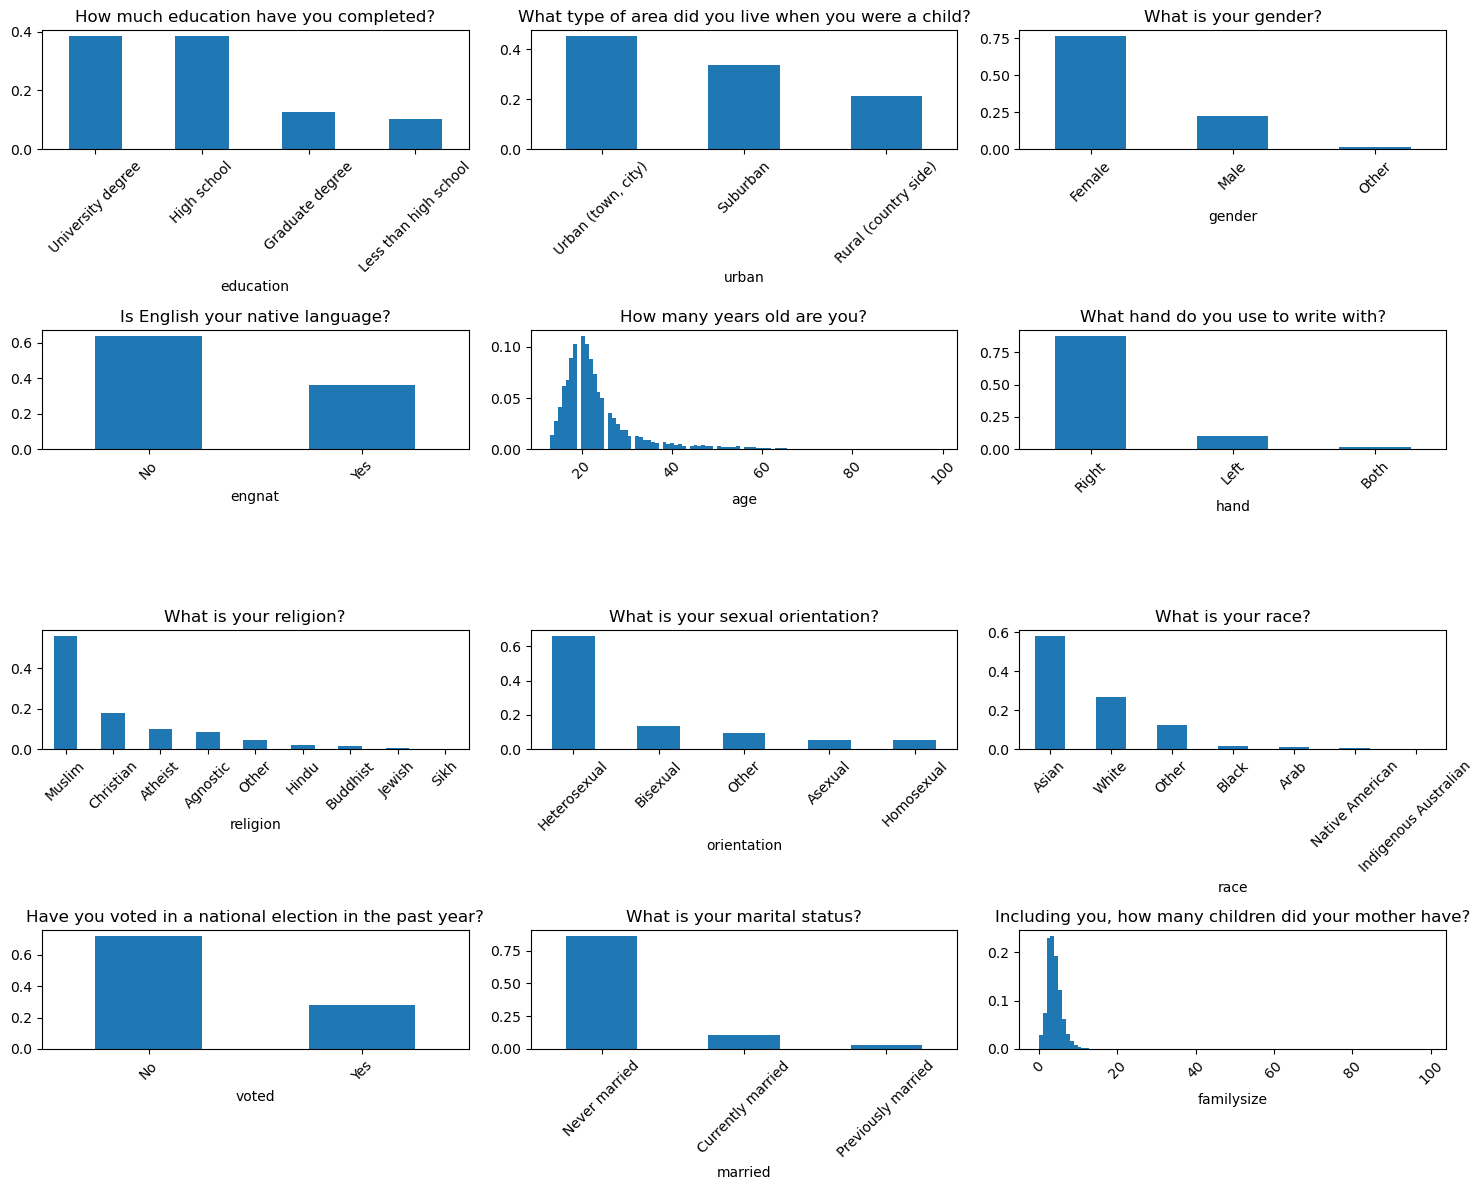

In [7]:
questions = {
    'education': ('How much education have you completed?', {
        1: 'Less than high school',
        2: 'High school',
        3: 'University degree',
        4: 'Graduate degree'
    }),
    'urban': ('What type of area did you live when you were a child?', {
        1: 'Rural (country side)',
        2: 'Suburban',
        3: 'Urban (town, city)'
    }),
    'gender': ('What is your gender?', {
        1: 'Male',
        2: 'Female',
        3: 'Other'
    }),
    'engnat': ('Is English your native language?', {
        1: 'Yes',
        0: 'No'
    }),
    'age': ('How many years old are you?', None),
    'hand': ('What hand do you use to write with?', {
        1: 'Right',
        2: 'Left',
        3: 'Both'
    }),
    'religion': ('What is your religion?', {
        1: 'Agnostic',
        2: 'Atheist',
        3: 'Buddhist',
        4: 'Christian',
        8: 'Hindu',
        9: 'Jewish',
        10: 'Muslim',
        11: 'Sikh',
        12: 'Other'
    }),
    'orientation': ('What is your sexual orientation?', {
        1: 'Heterosexual',
        2: 'Bisexual',
        3: 'Homosexual',
        4: 'Asexual',
        5: 'Other'
    }),
    'race': ('What is your race?', {
        10: 'Asian',
        20: 'Arab',
        30: 'Black',
        40: 'Indigenous Australian',
        50: 'Native American',
        60: 'White',
        70: 'Other'
    }),
    'voted': ('Have you voted in a national election in the past year?', {
        1: 'Yes',
        0: 'No'
    }),
    'married': ('What is your marital status?', {
        1: 'Never married',
        2: 'Currently married',
        3: 'Previously married'
    }),
    'familysize': ('Including you, how many children did your mother have?', None)
}


fig, axes = plt.subplots(4, 3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(questions.keys()):
    ax = axes[i // 3, i % 3]
    question,mapping = questions[column]
    
    if mapping is None:
        num_data = survey_q[column]
        num_data = num_data[ num_data<= 100] 
        ax.hist(num_data, bins=100,density=True)
    
    else:
        data = survey_q[column].map(mapping).value_counts()
 
        (data/data.sum()).plot(kind="bar", ax=ax)
    
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(question)
    ax.set_xlabel(column)

plt.tight_layout()
plt.show()

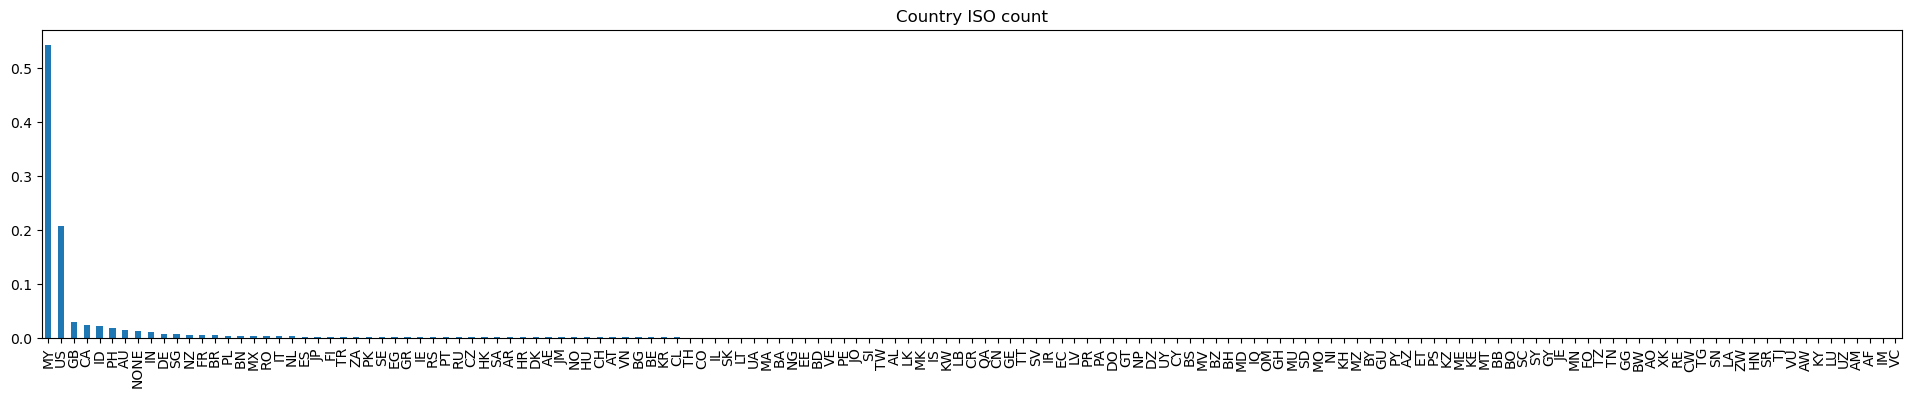

In [8]:
country_map_inv = {num:iso_c for iso_c,num in country_map.items()}

counts_ = survey_q["country"].map(country_map_inv).value_counts()
plt.figure(figsize=(24,4))
(counts_/counts_.sum()).plot(kind="bar")
plt.title("Country ISO count")
plt.show()


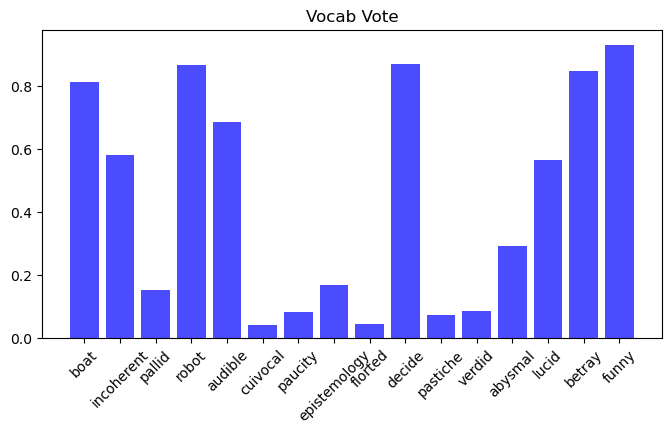

In [9]:
vcl_map = {
    "VCL1": "boat",
    "VCL2": "incoherent",
    "VCL3": "pallid",
    "VCL4": "robot",
    "VCL5": "audible",
    "VCL6": "cuivocal",
    "VCL7": "paucity",
    "VCL8": "epistemology",
    "VCL9": "florted",
    "VCL10": "decide",
    "VCL11": "pastiche",
    "VCL12": "verdid",
    "VCL13": "abysmal",
    "VCL14": "lucid",
    "VCL15": "betray",
    "VCL16": "funny"
}

plt.figure(figsize=(8,4))
n = len(survey_q)
for col in survey_q.columns:
    if "VCL" in col:
        plt.bar(vcl_map[col],sum(survey_q[col]/n),color="blue",alpha=0.7)

plt.title("Vocab Vote")
plt.xticks(rotation=45)
plt.show()

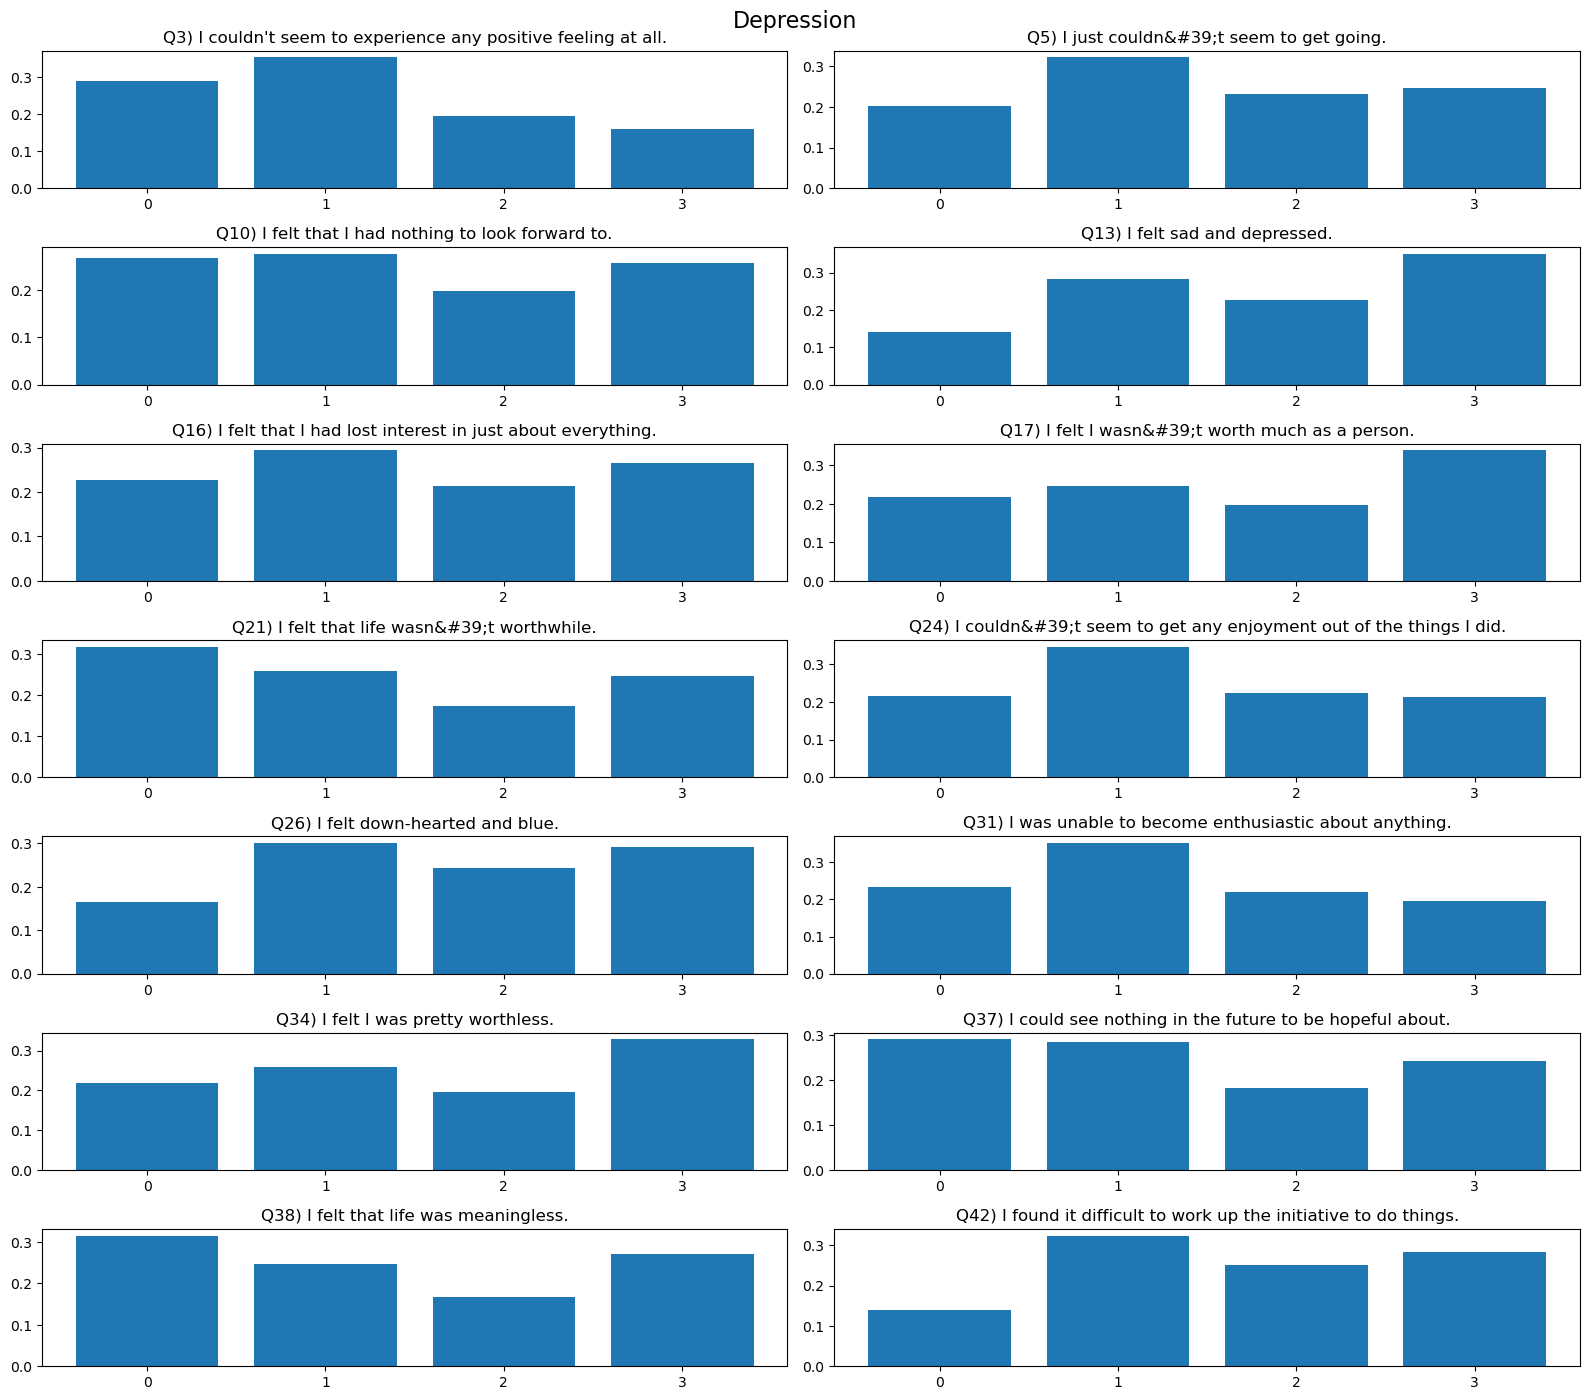

In [10]:
def plot_questions(Q_list,title,num_cols=3):
    num_rows = (len(Q_list) // num_cols+1)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_cols * num_rows))
    plt.subplots_adjust(hspace=0.5)
    
    for i, qid in enumerate(Q_list):
    
        ans = dass_qa[qid + "A"]
        que = qid + ") " + dass_42.loc[qid]["question"]
        
        counts_ = ans.value_counts().sort_index(ascending=True)
        row = i // num_cols
        col = i % num_cols
    
        ax = axes[row, col]
        ax.bar(counts_.index.map(lambda x: str(x)), counts_.values / counts_.values.sum())
        ax.set_title(que)
    
    for i in range(len(Depression), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])
    fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()
    

plot_questions(Depression,"Depression",2)

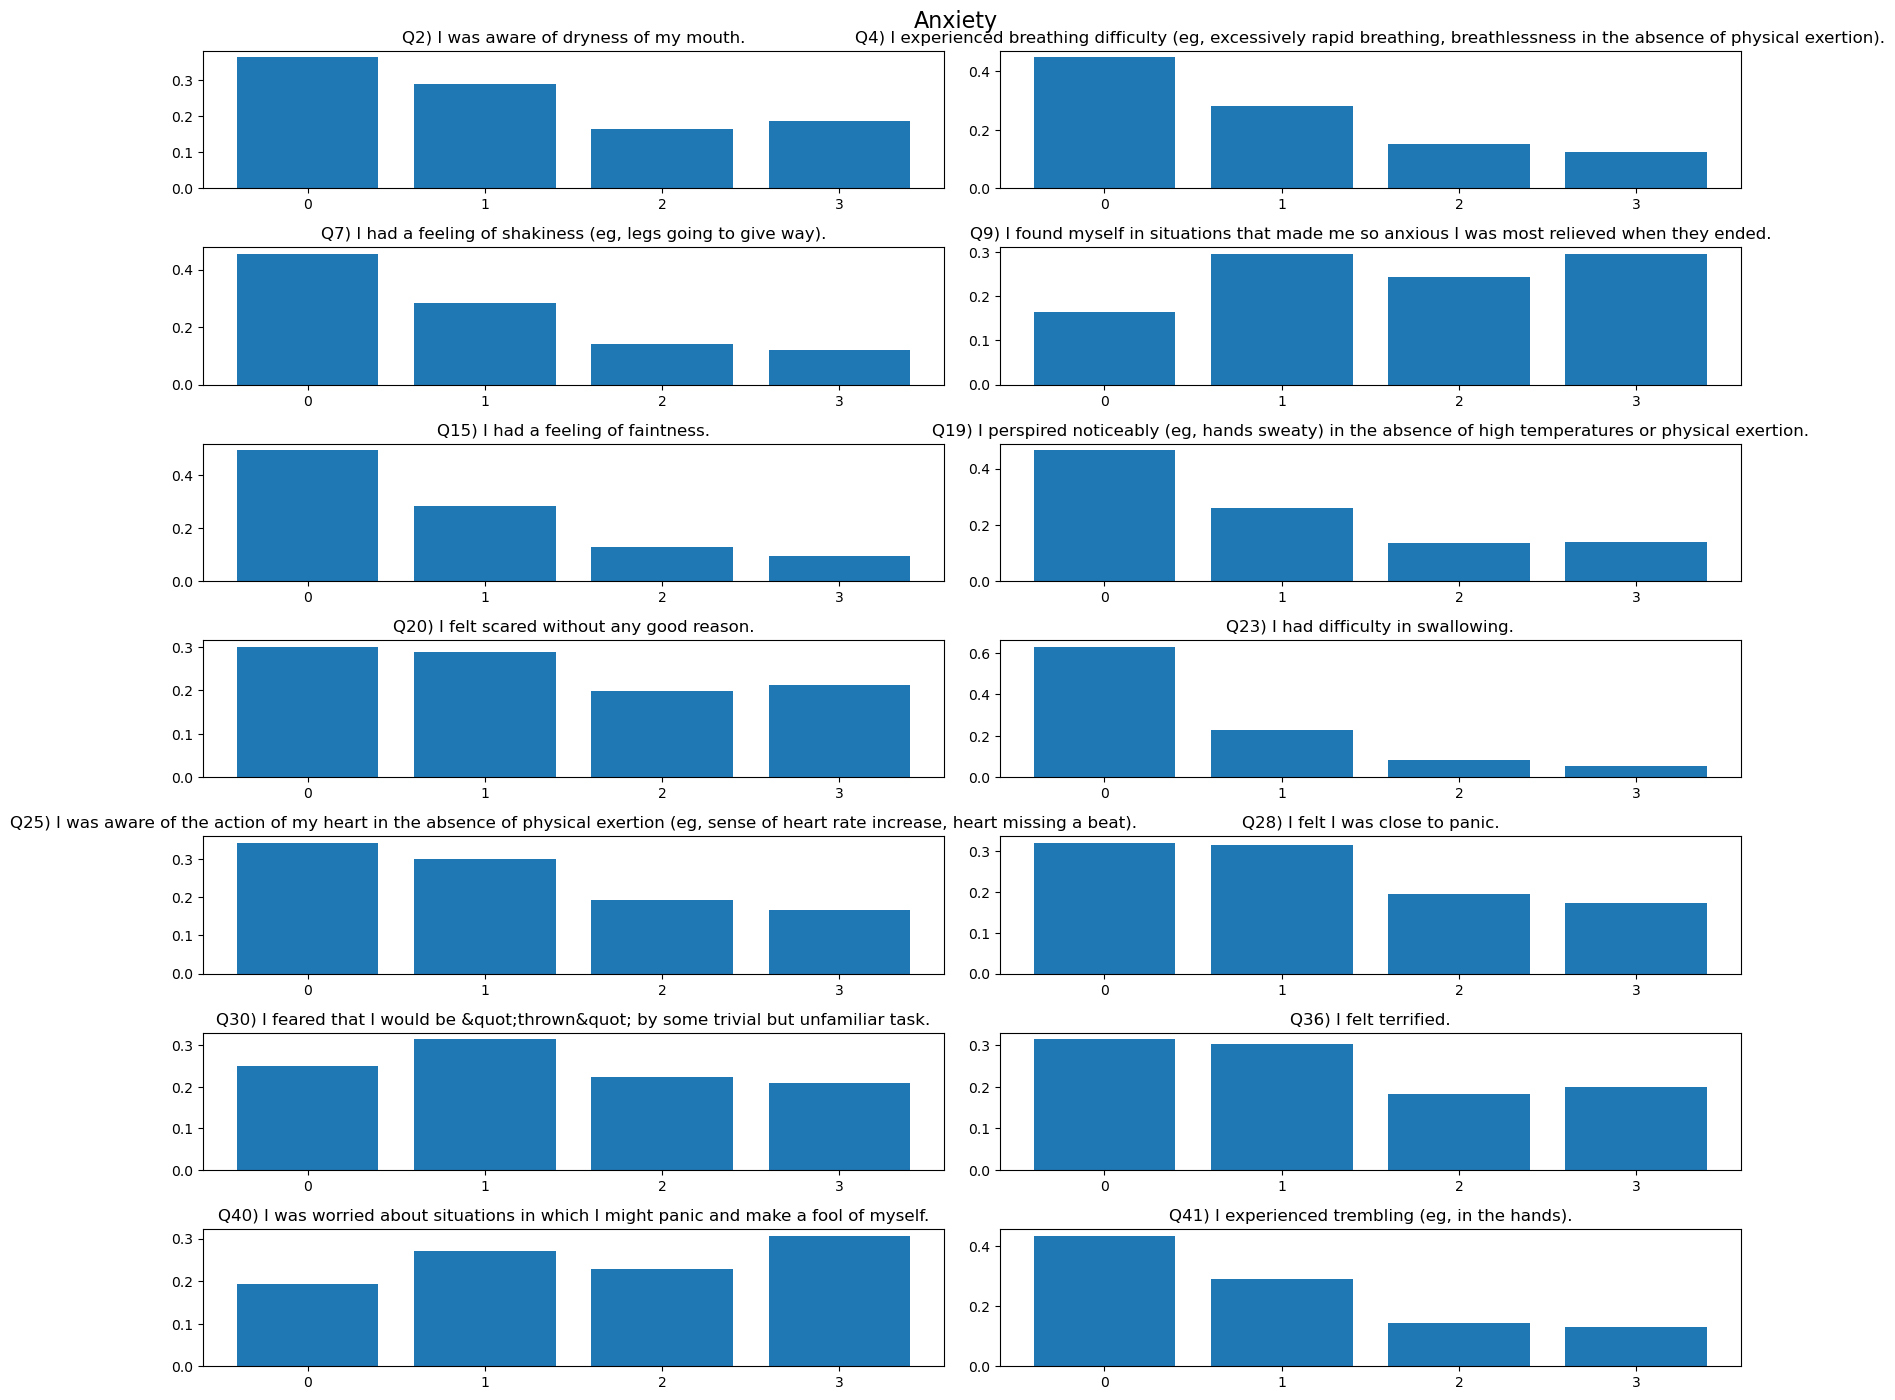

In [11]:
plot_questions(Anxiety,"Anxiety",num_cols=2)

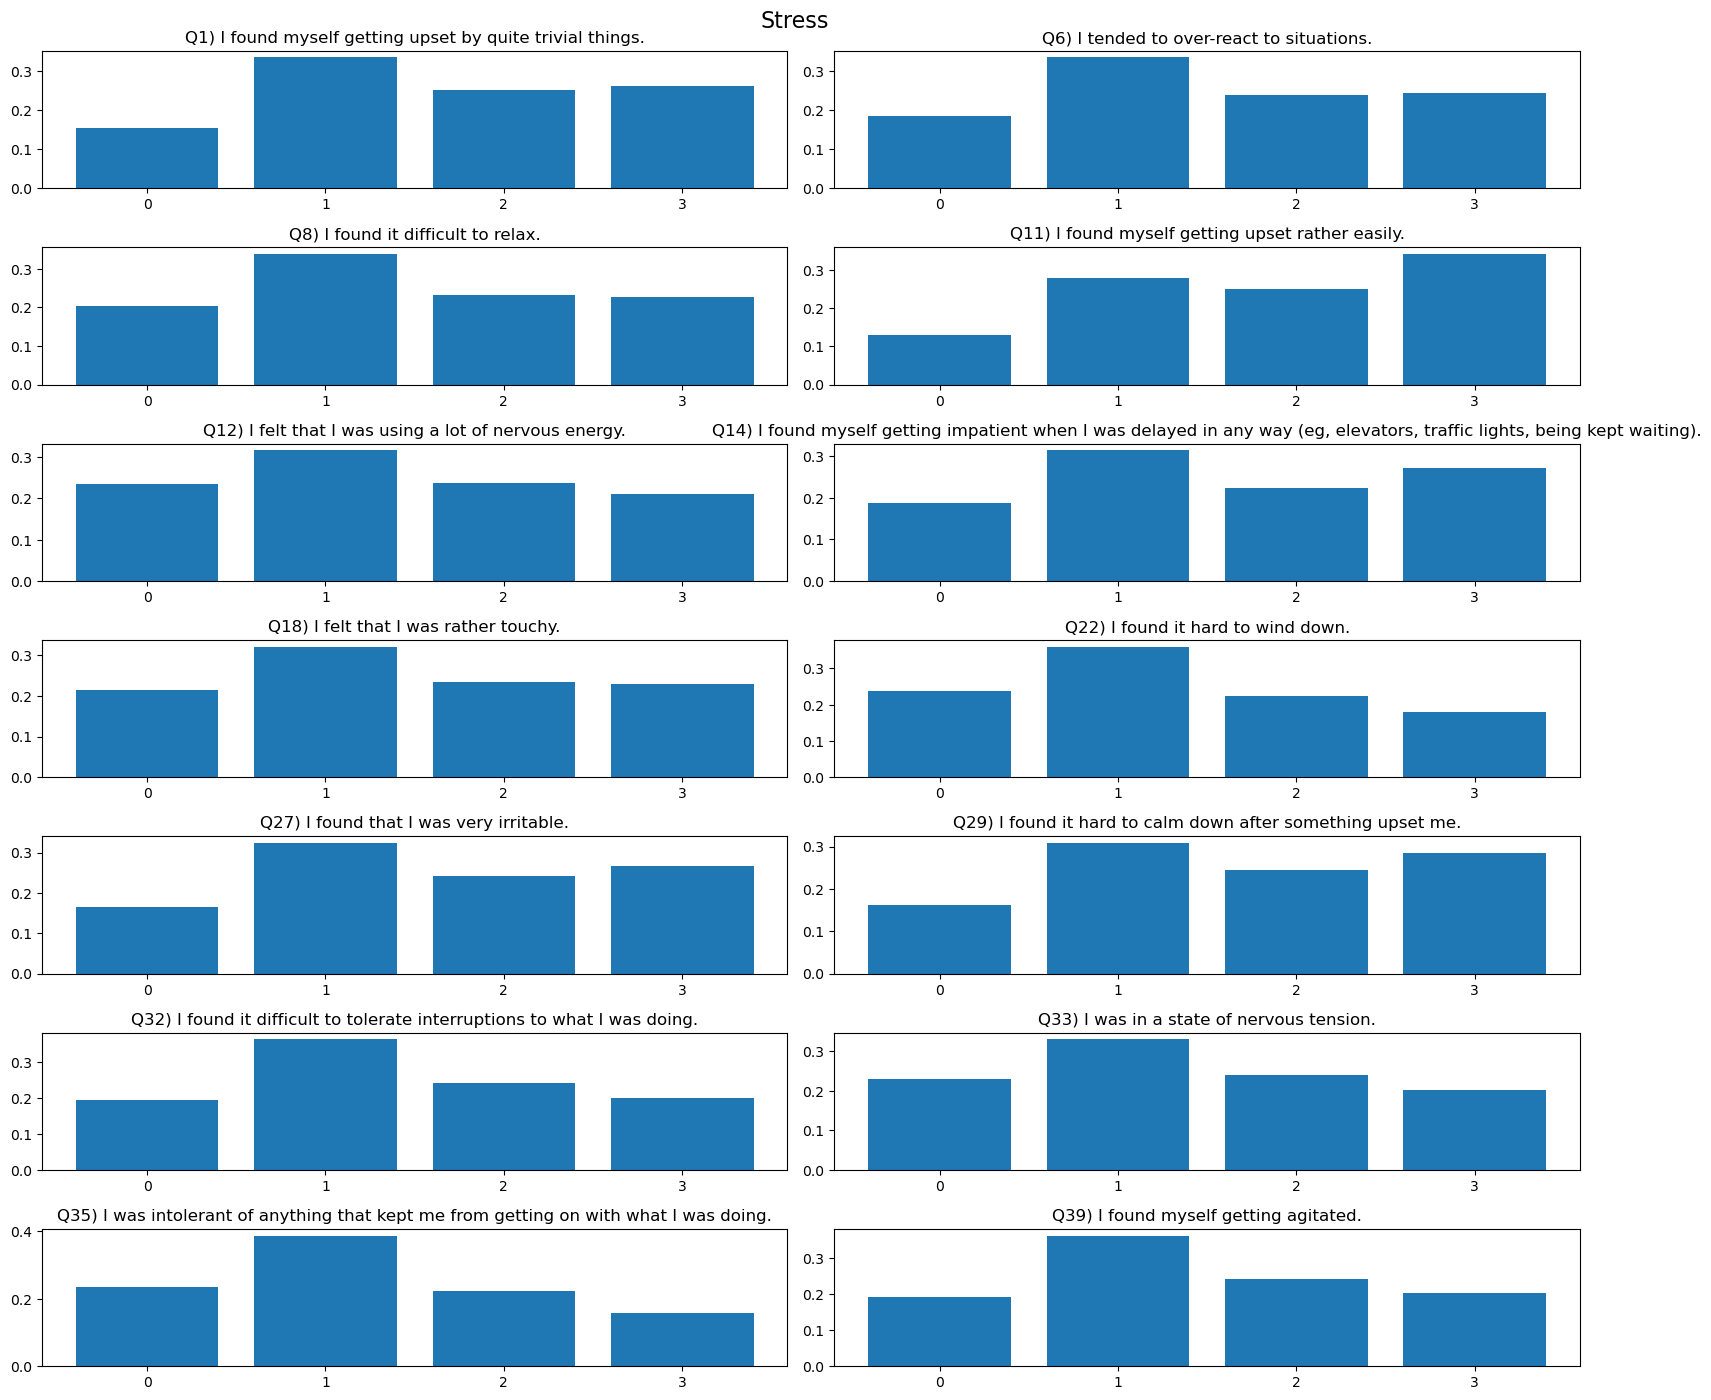

In [12]:
plot_questions(Stress,"Stress",2)

**TIPI Mapping**
```
0 = Not Answered
1 = Disagree strongly
2 = Disagree moderately
3 = Disagree a little
4 = Neither agree nor disagree
5 = Agree a little
6 = Agree moderately
7 = Agree strongly
```

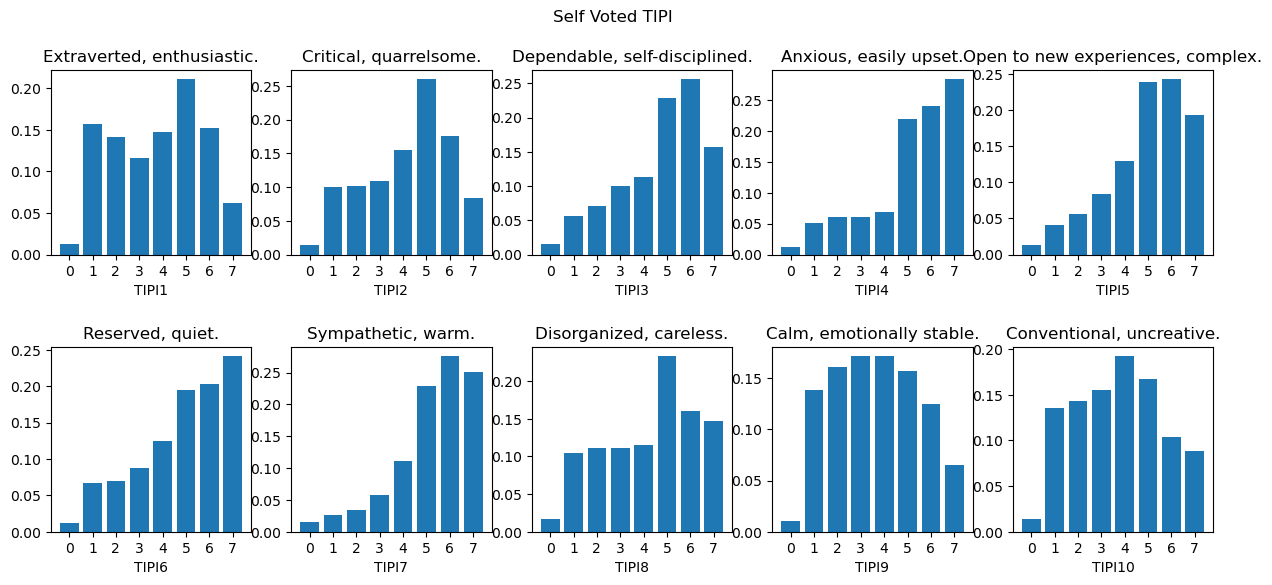

In [13]:
tipi = {
    "TIPI1": "Extraverted, enthusiastic.",
    "TIPI2": "Critical, quarrelsome.",
    "TIPI3": "Dependable, self-disciplined.",
    "TIPI4": "Anxious, easily upset.",
    "TIPI5": "Open to new experiences, complex.",
    "TIPI6": "Reserved, quiet.",
    "TIPI7": "Sympathetic, warm.",
    "TIPI8": "Disorganized, careless.",
    "TIPI9": "Calm, emotionally stable.",
    "TIPI10": "Conventional, uncreative."
}

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

plt.subplots_adjust(hspace=0.5)
i=0
for x in range(1,11):
    col = "TIPI"+str(x)    
    ax = axes[divmod(i,5)]
    counts_ = survey_q[col].value_counts().sort_index(ascending=True)
    ax.bar(counts_.index.map(lambda x: str(x)), counts_.values/counts_.values.sum())
    ax.set_xlabel(col)
    i+=1
    ax.set_title(tipi[col])
plt.suptitle("Self Voted TIPI")
plt.show()


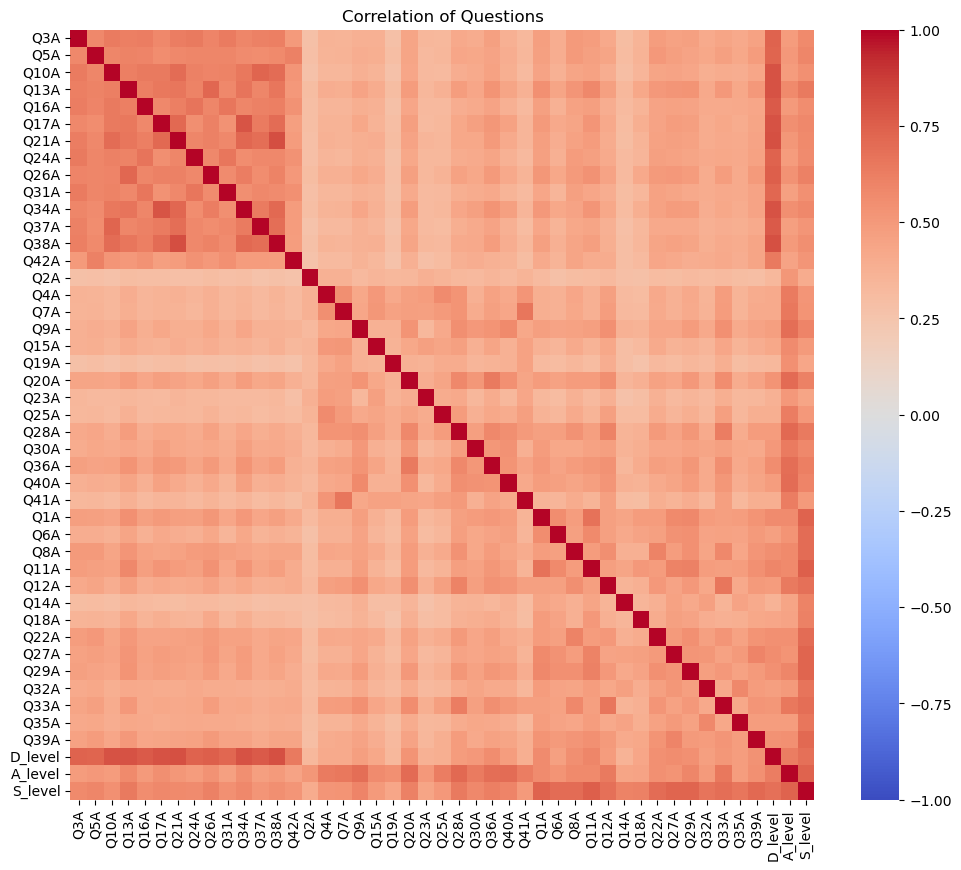

In [14]:
dass_qa_l = dass_qa.copy()
dass_qa_l["D_level"] = D_level
dass_qa_l["A_level"] = A_level
dass_qa_l["S_level"] = S_level

plt.figure(figsize=(12, 10))  
sns.heatmap(dass_qa_l.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of Questions")
plt.show()
del dass_qa_l

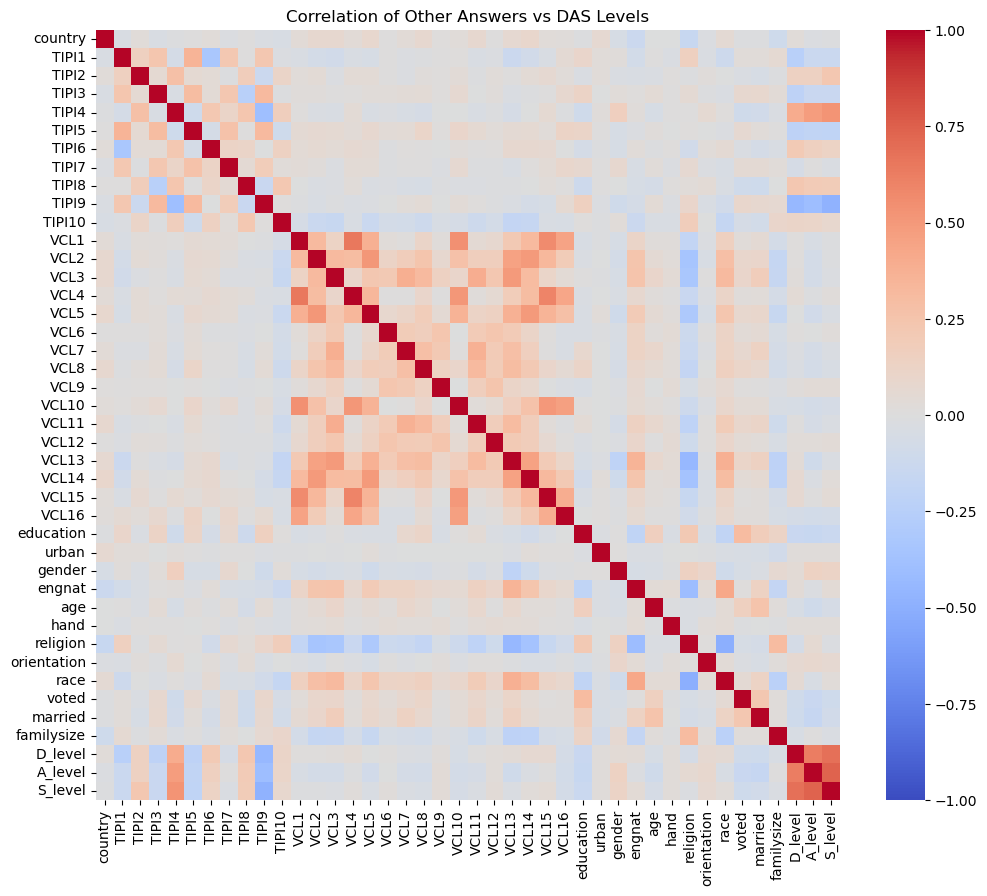

In [15]:
survey_q_l = survey_q.copy()
survey_q_l["D_level"] = D_level
survey_q_l["A_level"] = A_level
survey_q_l["S_level"] = S_level

plt.figure(figsize=(12, 10))  
sns.heatmap(survey_q_l.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of Other Answers vs DAS Levels")
plt.show()

del survey_q_l

# DT model to predict DAS levels with few Questions

In [16]:
from sklearn.tree import _tree

def traverse_dt(tree,feature_names,answers):
    tree_ = tree.tree_
    node = 0
    depth = 0
    question = 0
    memory = {}

    out = None
    while True:
        depth +=1
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            qid = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            if qid not in memory:
                question+=1
                memory[qid] = answers[qid+"A"]
            
            if memory[qid] <= threshold:
                node = tree_.children_left[node]
            else:
                node = tree_.children_right[node]
        else:
            out = np.argmax(tree_.value[node])
            break
    return out, question, depth

def predict_(tree,feature_names,X):
    N = len(X)
    y_pred = np.zeros(N,dtype=int)
    questions = np.zeros(N,dtype=int)
    depths = np.zeros(N,dtype=int)
    
    for i,(_,answers) in enumerate(X.iterrows()):
        y_pred[i],questions[i],depths[i] = traverse_dt(tree,feature_names,answers)
    return y_pred,questions,depths


# traverse_dt(Sl_dt,Stress,X_train.loc[0])

In [17]:
def freq_plot(data,title):
    mean_value = np.mean(data)
    median_value = np.median(data)
    std_deviation = np.std(data)
    min_ = min(data)
    max_ = max(data)
    plt.hist(data, bins=np.arange(min_, max_+1), alpha=0.7, color='blue', edgecolor='black', rwidth=0.85)
    plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean ({mean_value:.2f})')
    plt.axvline(median_value, color='green', linestyle='--', label=f'Median ({median_value})')

    plt.annotate(f'std({std_deviation:.2f})', xy=(0.85, 0.7), xycoords='axes fraction', fontsize=10, color='purple', va='center')
    plt.annotate(f'min({min_})', xy=(0.85, 0.65), xycoords='axes fraction', fontsize=10, color='purple', va='center')
    plt.annotate(f'max({max_})', xy=(0.85, 0.6), xycoords='axes fraction', fontsize=10, color='purple', va='center')

    plt.legend()

    # plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)

Total Data Size: 39775
Train Data Size: 27842
Test Data Size: 11933
Test Proportion: 0.3
Random Seed: 69420
DT criterion: entropy


Depression Predictor
Accuracy: 0.8324813542277717
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2677
           1       0.63      0.65      0.64      1119
           2       0.74      0.74      0.74      2157
           3       0.73      0.71      0.72      2034
           4       0.93      0.93      0.93      3946

    accuracy                           0.83     11933
   macro avg       0.79      0.79      0.79     11933
weighted avg       0.83      0.83      0.83     11933



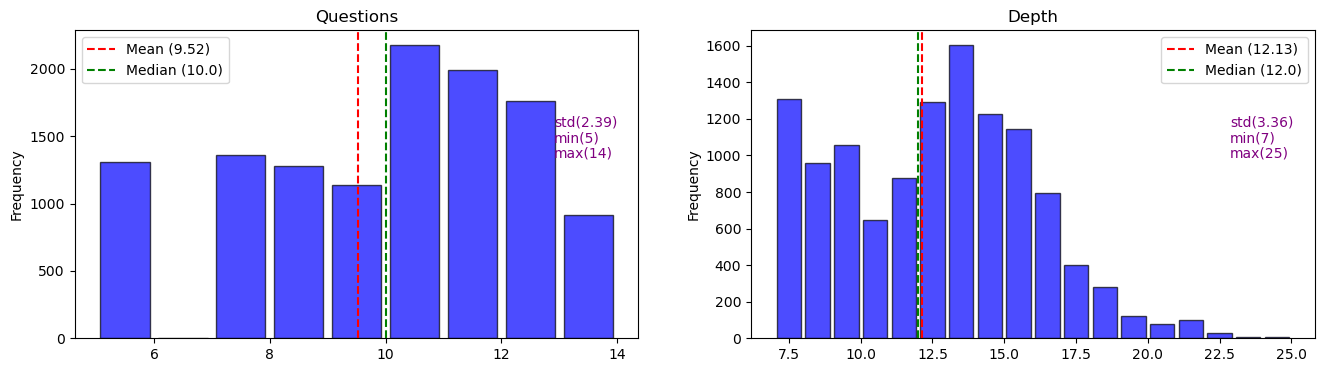

Anxiety Predictor
Accuracy: 0.7820330176820581
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2934
           1       0.42      0.45      0.43       812
           2       0.68      0.65      0.66      2151
           3       0.59      0.58      0.59      1846
           4       0.91      0.90      0.91      4190

    accuracy                           0.78     11933
   macro avg       0.70      0.70      0.70     11933
weighted avg       0.78      0.78      0.78     11933



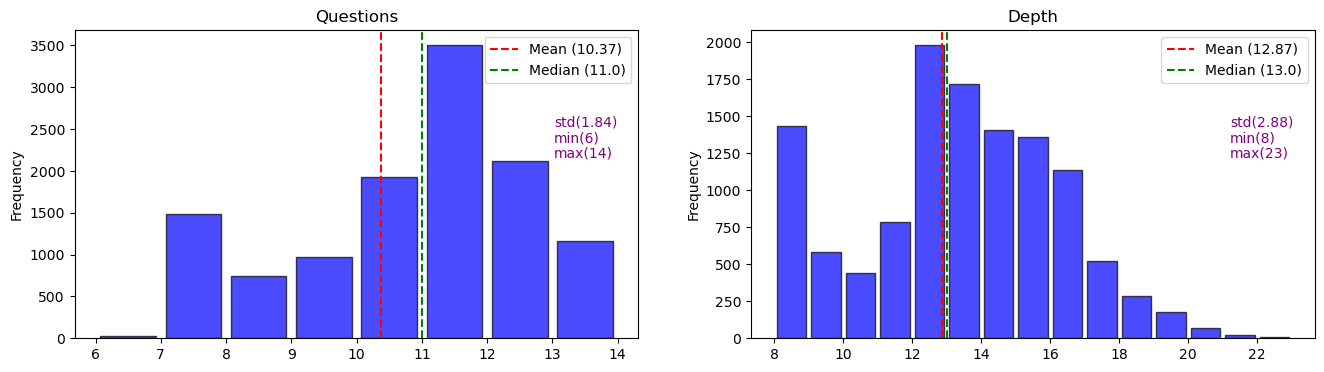

Stress Predictor
Accuracy: 0.7948546048772313
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3568
           1       0.59      0.62      0.61      1470
           2       0.72      0.71      0.72      2632
           3       0.77      0.75      0.76      2591
           4       0.85      0.88      0.87      1672

    accuracy                           0.79     11933
   macro avg       0.77      0.78      0.77     11933
weighted avg       0.80      0.79      0.79     11933



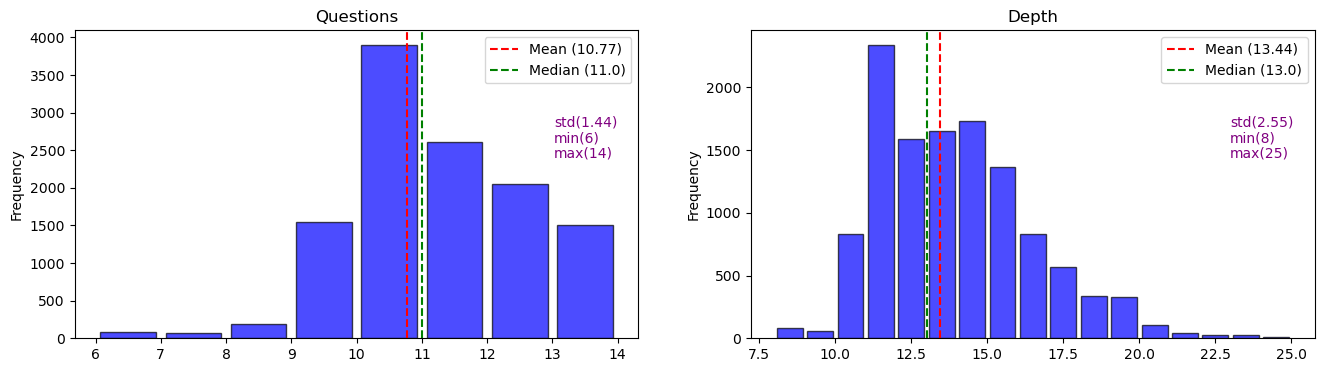

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report

t_size = 0.3
r_state = 69420
criterion='entropy' # entropy, gini, log_loss
# Depression Level Predicting Decision Tree
X_train, X_test, y_train, y_test = train_test_split(dass_qa[Ait(Depression)], D_level, test_size=t_size, random_state=r_state, shuffle=True)

print("Total Data Size:",len(dass_qa))
print("Train Data Size:",len(X_train))
print("Test Data Size:",len(X_test))
print("Test Proportion:",t_size)
print("Random Seed:",r_state)
print("DT criterion:", criterion)
print("\n")

Dl_dt = DecisionTreeClassifier(criterion=criterion, random_state=r_state)
Dl_dt.fit(X_train, y_train)

y_pred,questions,depths = predict_(Dl_dt,Depression,X_test)

print("Depression Predictor")
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
freq_plot(questions,"Questions")
plt.subplot(1,2,2)
freq_plot(depths,"Depth")
plt.show()

del X_test, X_train, y_test, y_train, y_pred

# Anxiety Level Predicting Decision Tree
X_train, X_test, y_train, y_test = train_test_split(dass_qa[Ait(Anxiety)], A_level,  test_size=t_size, random_state=r_state, shuffle=True)
Al_dt = DecisionTreeClassifier(criterion=criterion, random_state=r_state)
Al_dt.fit(X_train, y_train)


y_pred,questions,depths = predict_(Al_dt,Anxiety,X_test)

print("Anxiety Predictor")
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
freq_plot(questions,"Questions")
plt.subplot(1,2,2)
freq_plot(depths,"Depth")
plt.show()
del X_test, X_train, y_test, y_train, y_pred

# Stress Level Predicting Decision Tree
X_train, X_test, y_train, y_test = train_test_split(dass_qa[Ait(Stress)], S_level, test_size=t_size, random_state=r_state, shuffle=True)
Sl_dt = DecisionTreeClassifier(criterion=criterion, random_state=r_state)
Sl_dt.fit(X_train, y_train)

y_pred,questions,depths = predict_(Sl_dt,Stress,X_test)

print("Stress Predictor")
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
freq_plot(questions,"Questions")
plt.subplot(1,2,2)
freq_plot(depths,"Depth")
plt.show()
del X_test, X_train, y_test, y_train, y_pred

In [21]:
import cloudpickle

def pickle_it(model,filename):
    with open(f'models/{filename}.pkl', 'wb') as file:
        cloudpickle.dump(model, file)
    print(filename,"saved!")

pickle_it(Dl_dt,"Dl_dt")
pickle_it(Al_dt,"Al_dt")
pickle_it(Sl_dt,"Sl_dt")

Dl_dt saved!
Al_dt saved!
Sl_dt saved!


In [22]:
import sklearn
print(sklearn.__version__)


1.2.2
